In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV   #Perforing grid search
from sklearn import metrics   #Additional scklearn functions

In [ ]:
# 版本号：
# pandas == 1.0.1
# numpy == 1.18.1
# xgboost == 0.90
# scikit-learn == 0.22.1

In [2]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4 # 画图大小的参数

In [3]:
train = pd.read_csv('dataset/train_modified.csv')
target = 'Disbursed' # 设置label
IDcol = 'ID' # ID列，后续要去除

In [4]:
# 核心函数
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        #XGBoost有一个很有用的函数“cv”，这个函数可以在每一次迭代中使用交叉验证，并返回理想的决策树数量。
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        # cvresult.shape[0] 当前最好的结果迭代次数
        # print("cvresult:", cvresult.shape[0])
        # print(cvresult)
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    # 返回预测标签  
    dtrain_predictions = alg.predict(dtrain[predictors])
    # 返回预测属于某标签的概率
    # 二分类则得到[(px1,px2),()]，分别表示预测为0的概率和预测为1的概率
    # [:,1]是取二维数组中第二维的所有数据，预测为1的概率
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    # 输出结果 图的形式
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return cvresult.shape[0]

In [5]:
predictors = [x for x in train.columns if x not in [target, IDcol]] # 设置分类的列


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.898664


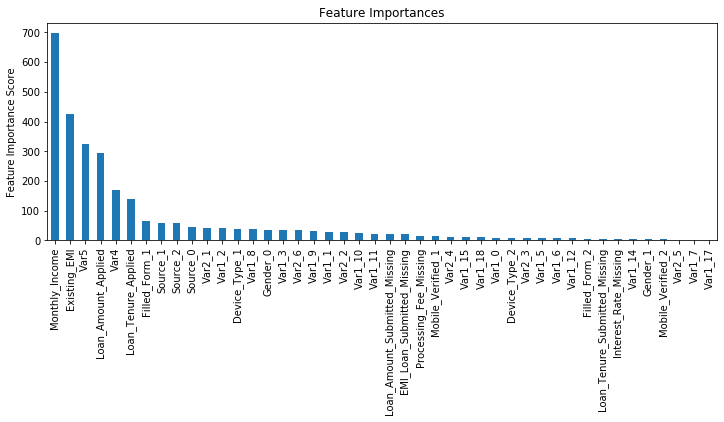

In [6]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
best_n_estimators = modelfit(xgb1, train, predictors, target)

In [7]:
best_n_estimators # 最佳迭代次数
# 以下的 n_estimators 要根据这里结果设置

148

In [8]:
# 改变最大深度和最小child权重
# 可以使用交叉验证来验证
param_test1 = {
 'max_depth':range(3,10,2), # 从3 - 10 步长为2 （3,5,7,9）
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

F:\Anaconda\envs\xgboost\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([ 8.39293747,  7.51149678,  8.11946988, 13.61376677, 12.15367403,
         13.47792735, 18.01977477, 17.67449827, 18.55953074, 23.10995264,
         21.48749561, 20.04475603]),
  'std_fit_time': array([0.39729264, 0.22193665, 0.49334979, 0.3253442 , 1.52834096,
         1.60469477, 0.60912121, 0.67771863, 1.19611674, 0.59073337,
         0.57280993, 1.98071527]),
  'mean_score_time': array([0.08098316, 0.0789887 , 0.07140923, 0.08198094, 0.08437443,
         0.08896232, 0.09753923, 0.09793787, 0.09514642, 0.10850978,
         0.10671377, 0.08916106]),
  'std_score_time': array([0.01269981, 0.00674618, 0.00529997, 0.0064458 , 0.00651235,
         0.00438848, 0.00380551, 0.0053671 , 0.005109  , 0.00603023,
         0.0062126 , 0.01132969]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

In [ ]:
# 假设最优解在max_depth = 5， min_child_weight = 5
# 在其附近再找最优解
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
# 调整gamma参数
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
# 调整列采样和行采样的比例（增加随机性降低过拟合）
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
# 调整正则项
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
# 再次尝试最优解附近的正则项 假设是0.01
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

In [ ]:
# 将最优结果整合，重新训练
# gamma = 0
# max_depth = 4 min_child_weight = 6
# colsample_bytree = 0.8
# reg_alpha = 0.005
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors, target)

In [ ]:
# 最后，我们尝试降低学习率，并进一步增加更多的树.
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000, # 增加迭代次数
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors, target)